In [177]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

In [178]:
def logBin(degs, counts, num_bins=40):
    #based off of https://stackoverflow.com/questions/16489655/plotting-log-binned-network-degree-distributions
    x_max = np.log10(np.max(degs))
    y_max = np.log10(np.max(counts))
    base_max = np.max([x_max,y_max])
    x_min = np.log10(np.min(degs[degs != 0]))
    
    bins = np.logspace(x_min,base_max,num=num_bins)
    
    bin_means_y = (np.histogram(degs,bins,weights=counts)[0] / np.histogram(degs,bins)[0])
    bin_means_x = (np.histogram(degs,bins,weights=degs)[0] / np.histogram(degs,bins)[0])

    return bin_means_x,bin_means_y

100%|██████████| 200/200 [00:00<00:00, 225.33it/s]


Network model:  Erdos-Reyni
---Centrality measures---
Degree:
max     0.13013013013013014
mean    0.09995795795795796
min     0.07207207207207207

Closeness:
max     0.534796573875803
mean    0.5263064885190732
min     0.5184224182667359


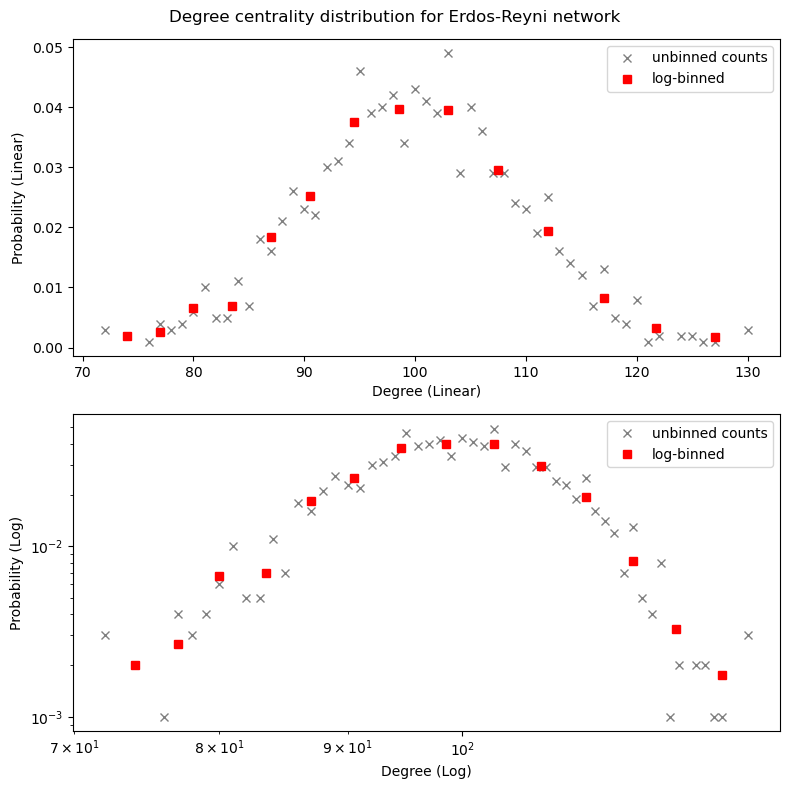

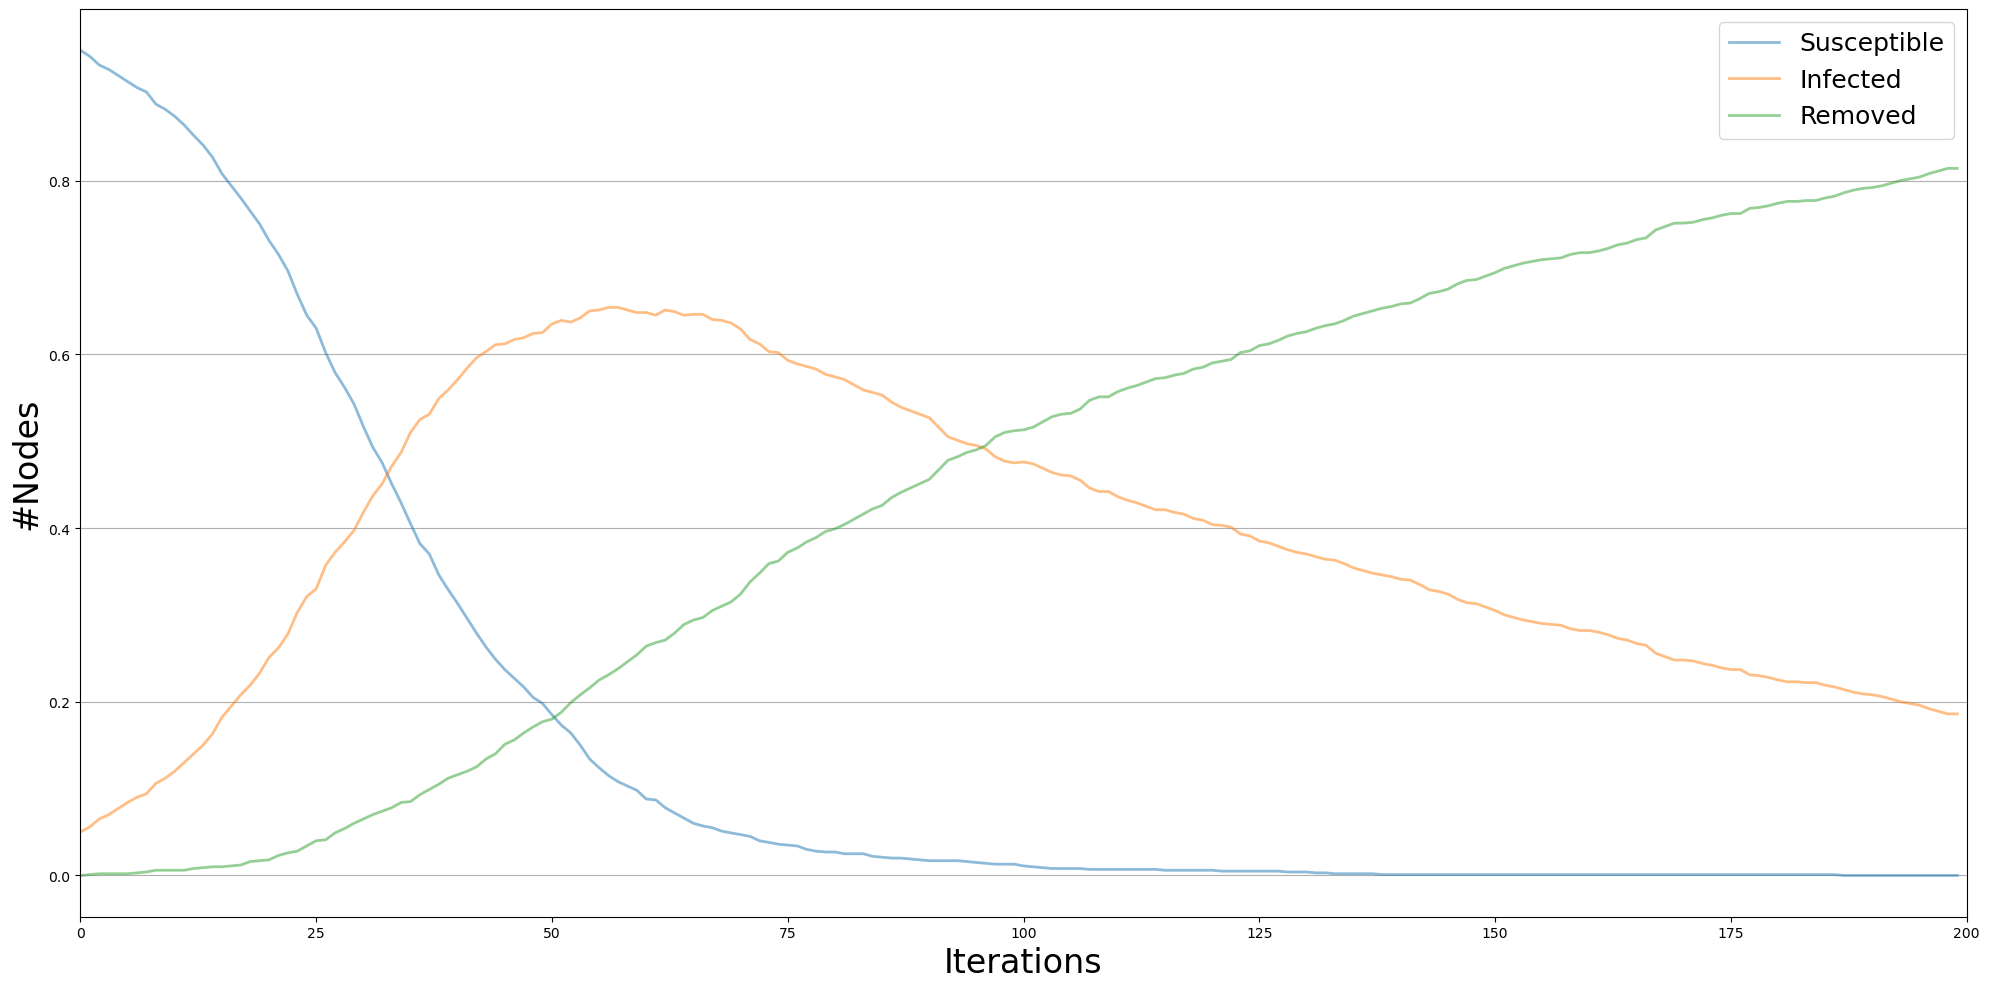

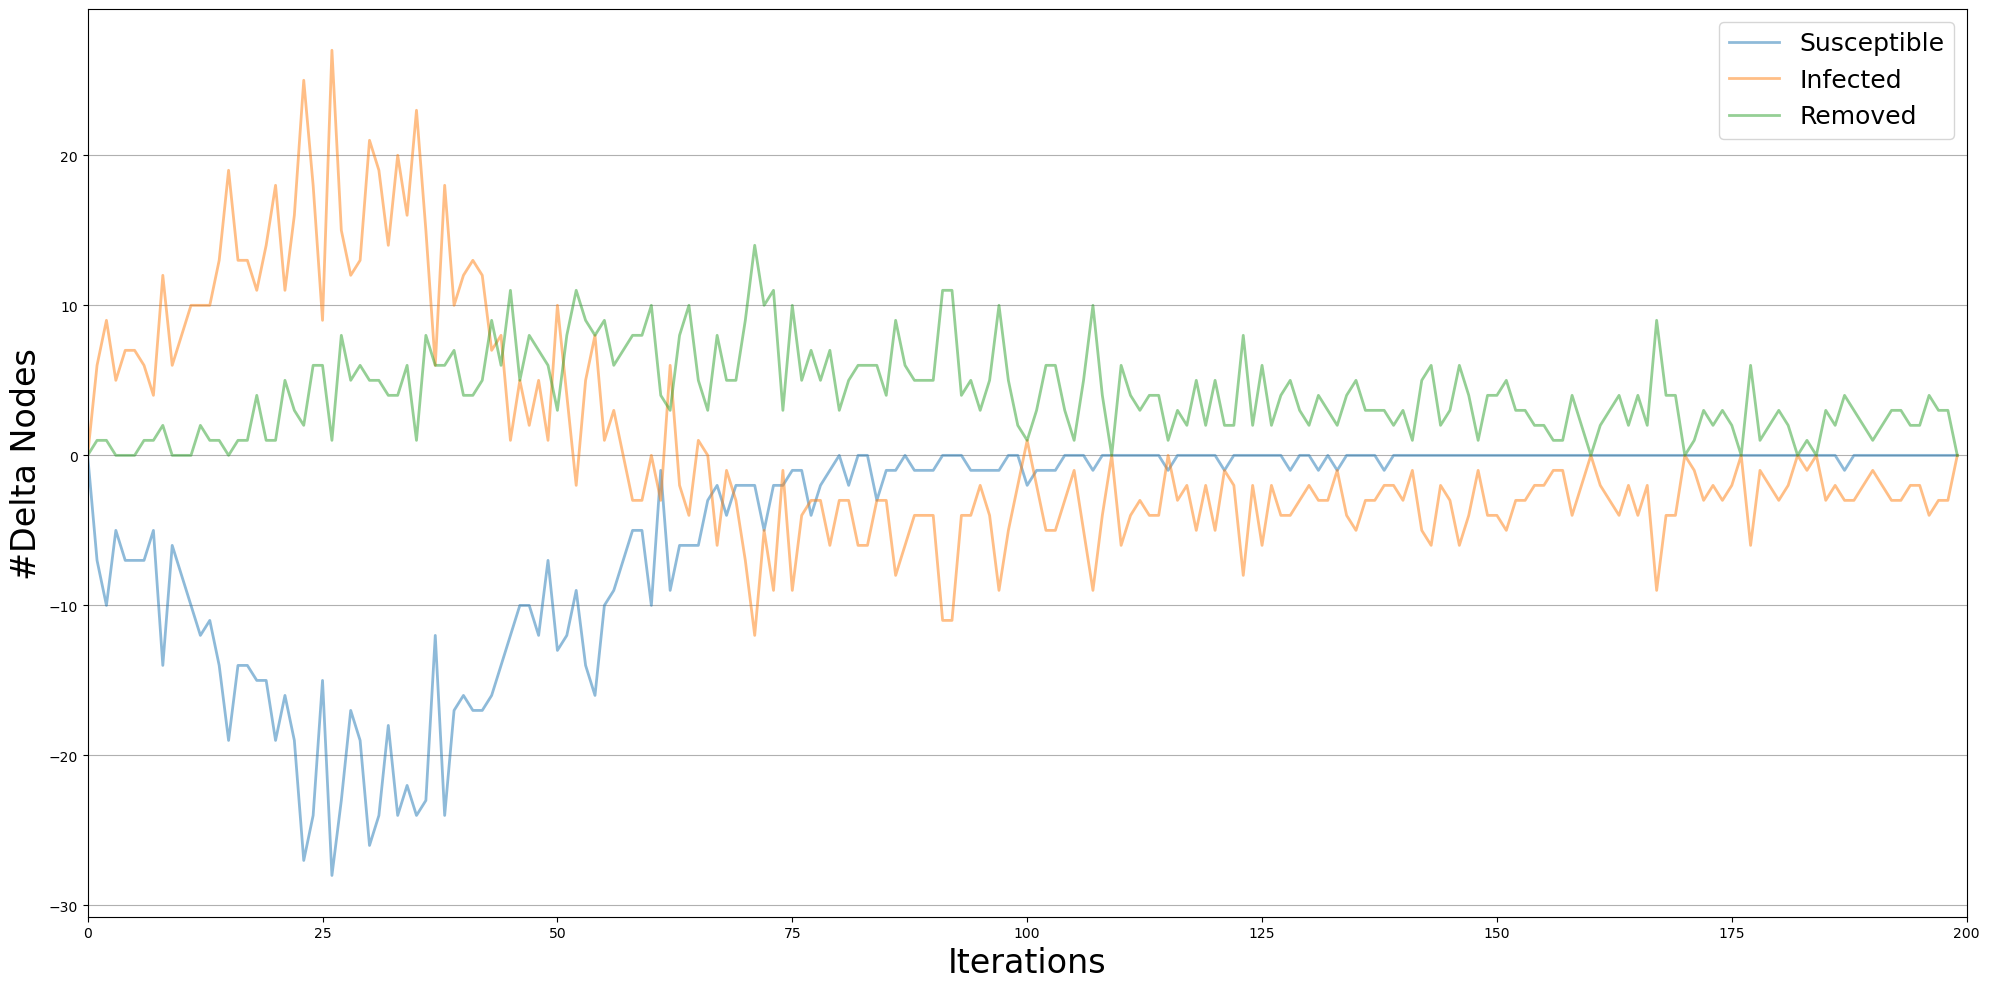

100%|██████████| 200/200 [00:00<00:00, 205.25it/s]


Network model:  Watts-Strogatz
---Centrality measures---
Degree:
max     0.1091091091091091
mean    0.10010010010010012
min     0.09109109109109109

Closeness:
max     0.5252365930599369
mean    0.5009700915845883
min     0.46164510166358597


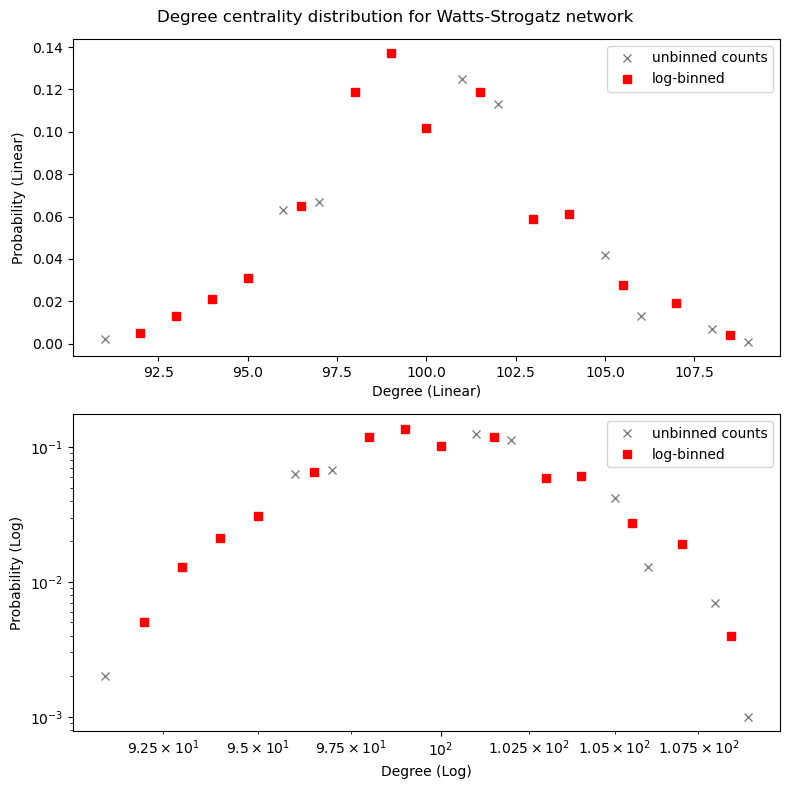

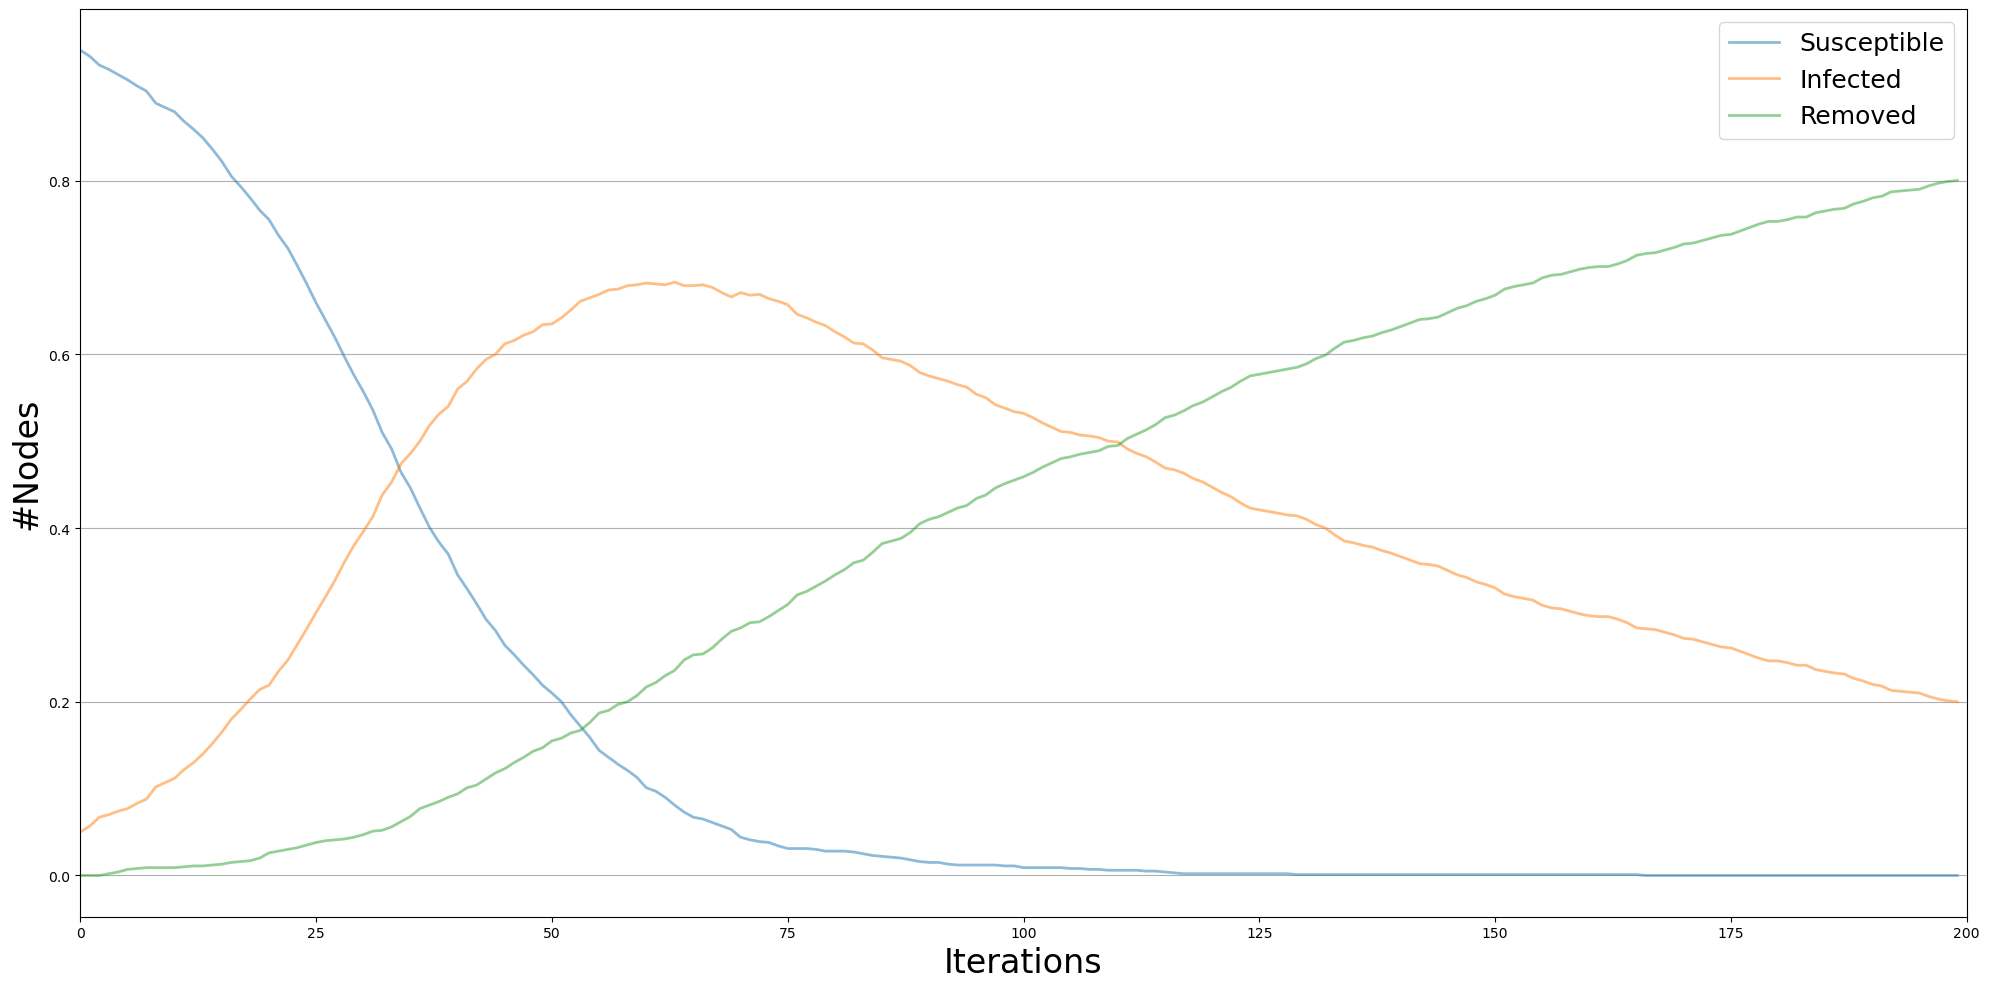

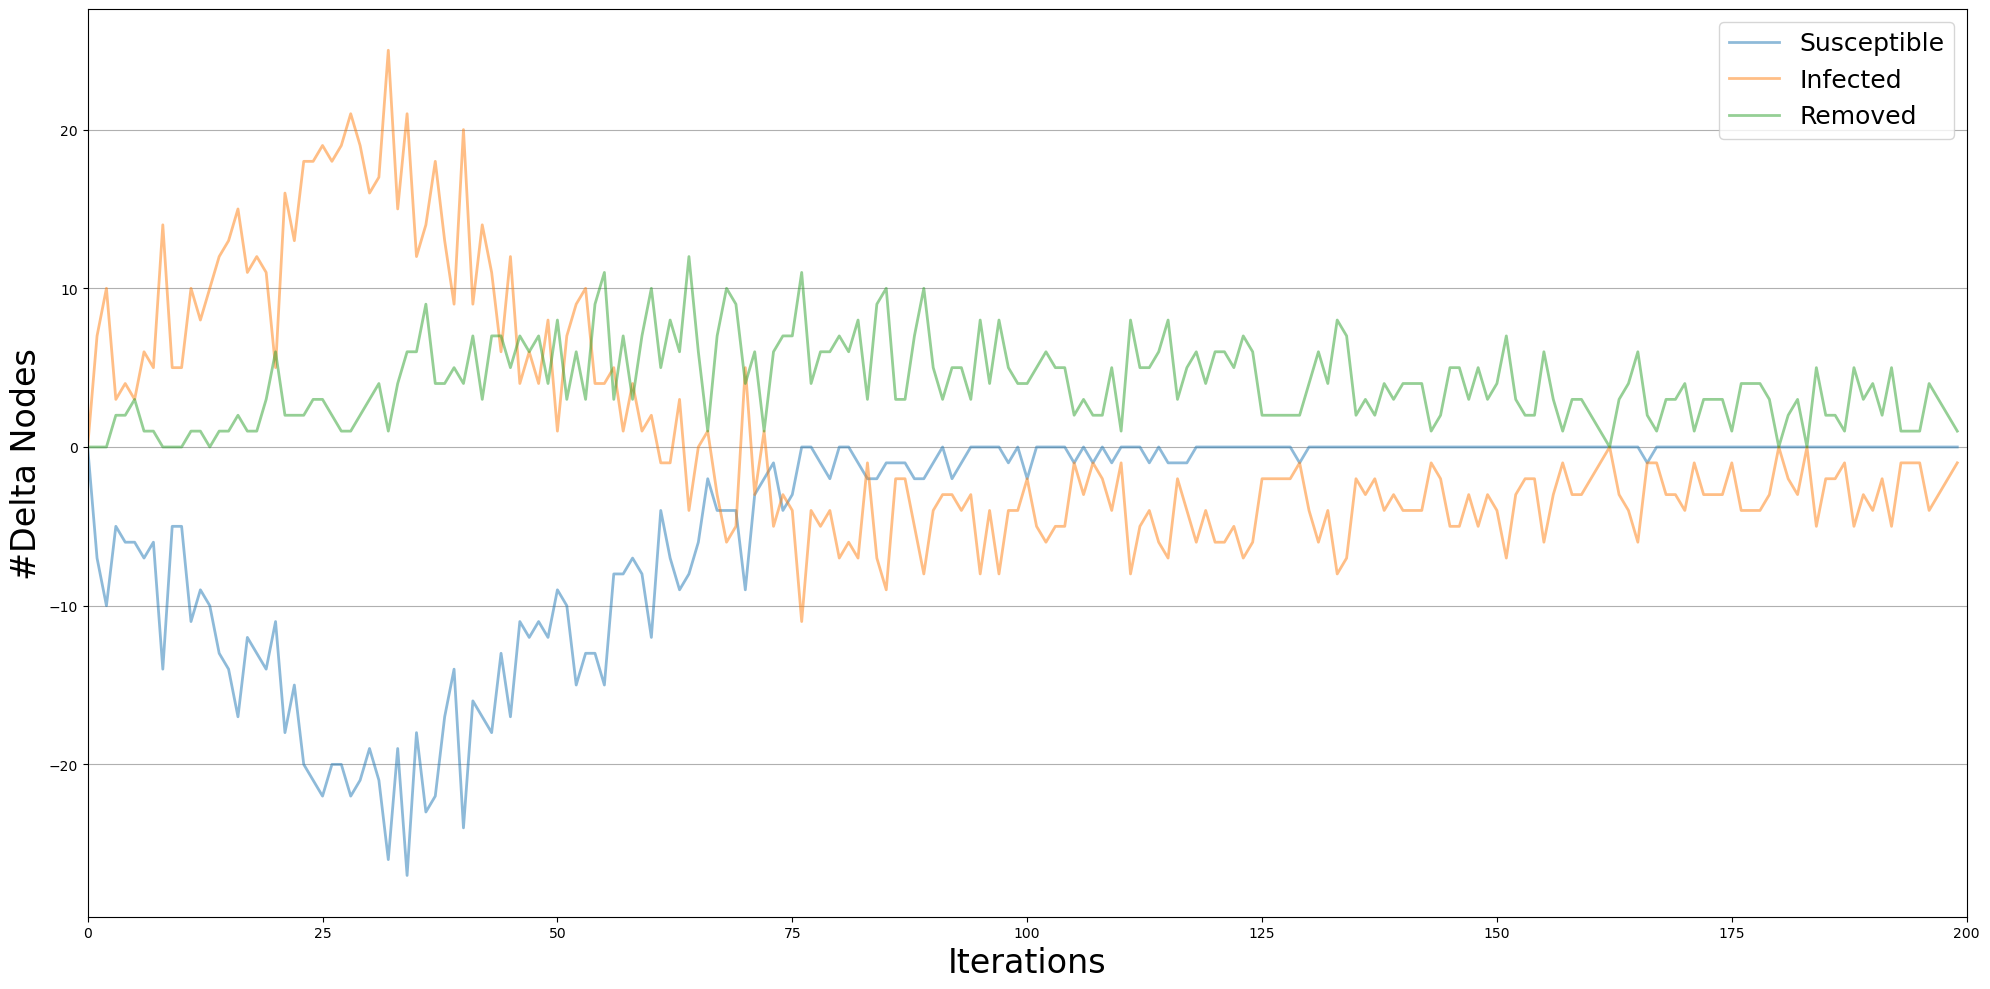

100%|██████████| 200/200 [00:01<00:00, 123.85it/s]


Network model:  Barabasi Albert
---Centrality measures---
Degree:
max     0.5225225225225225
mean    0.18018018018018017
min     0.10010010010010009

Closeness:
max     0.676829268292683
mean    0.5508749366628007
min     0.5263435194942044


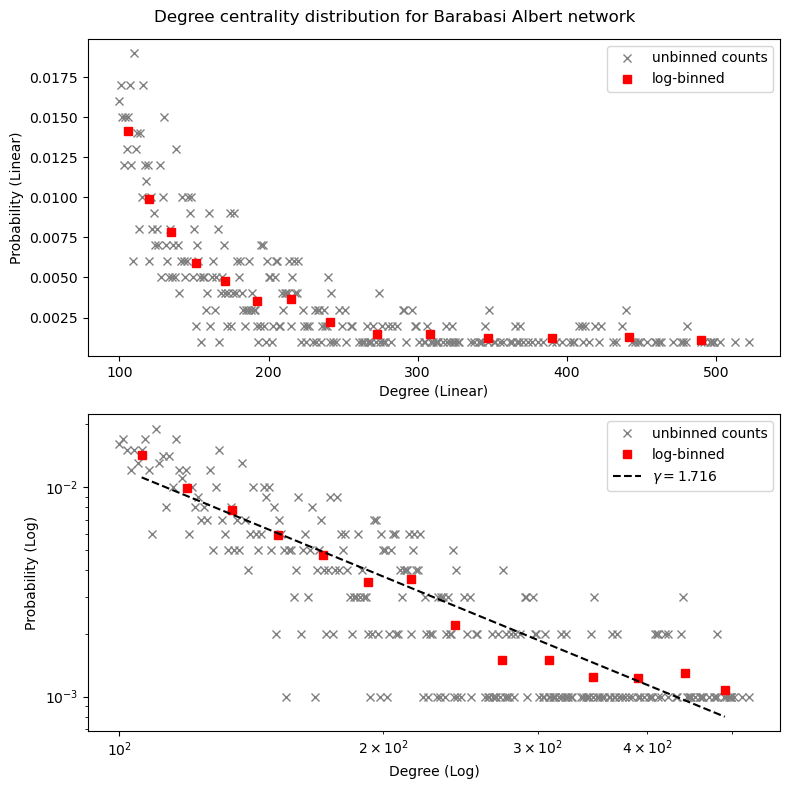

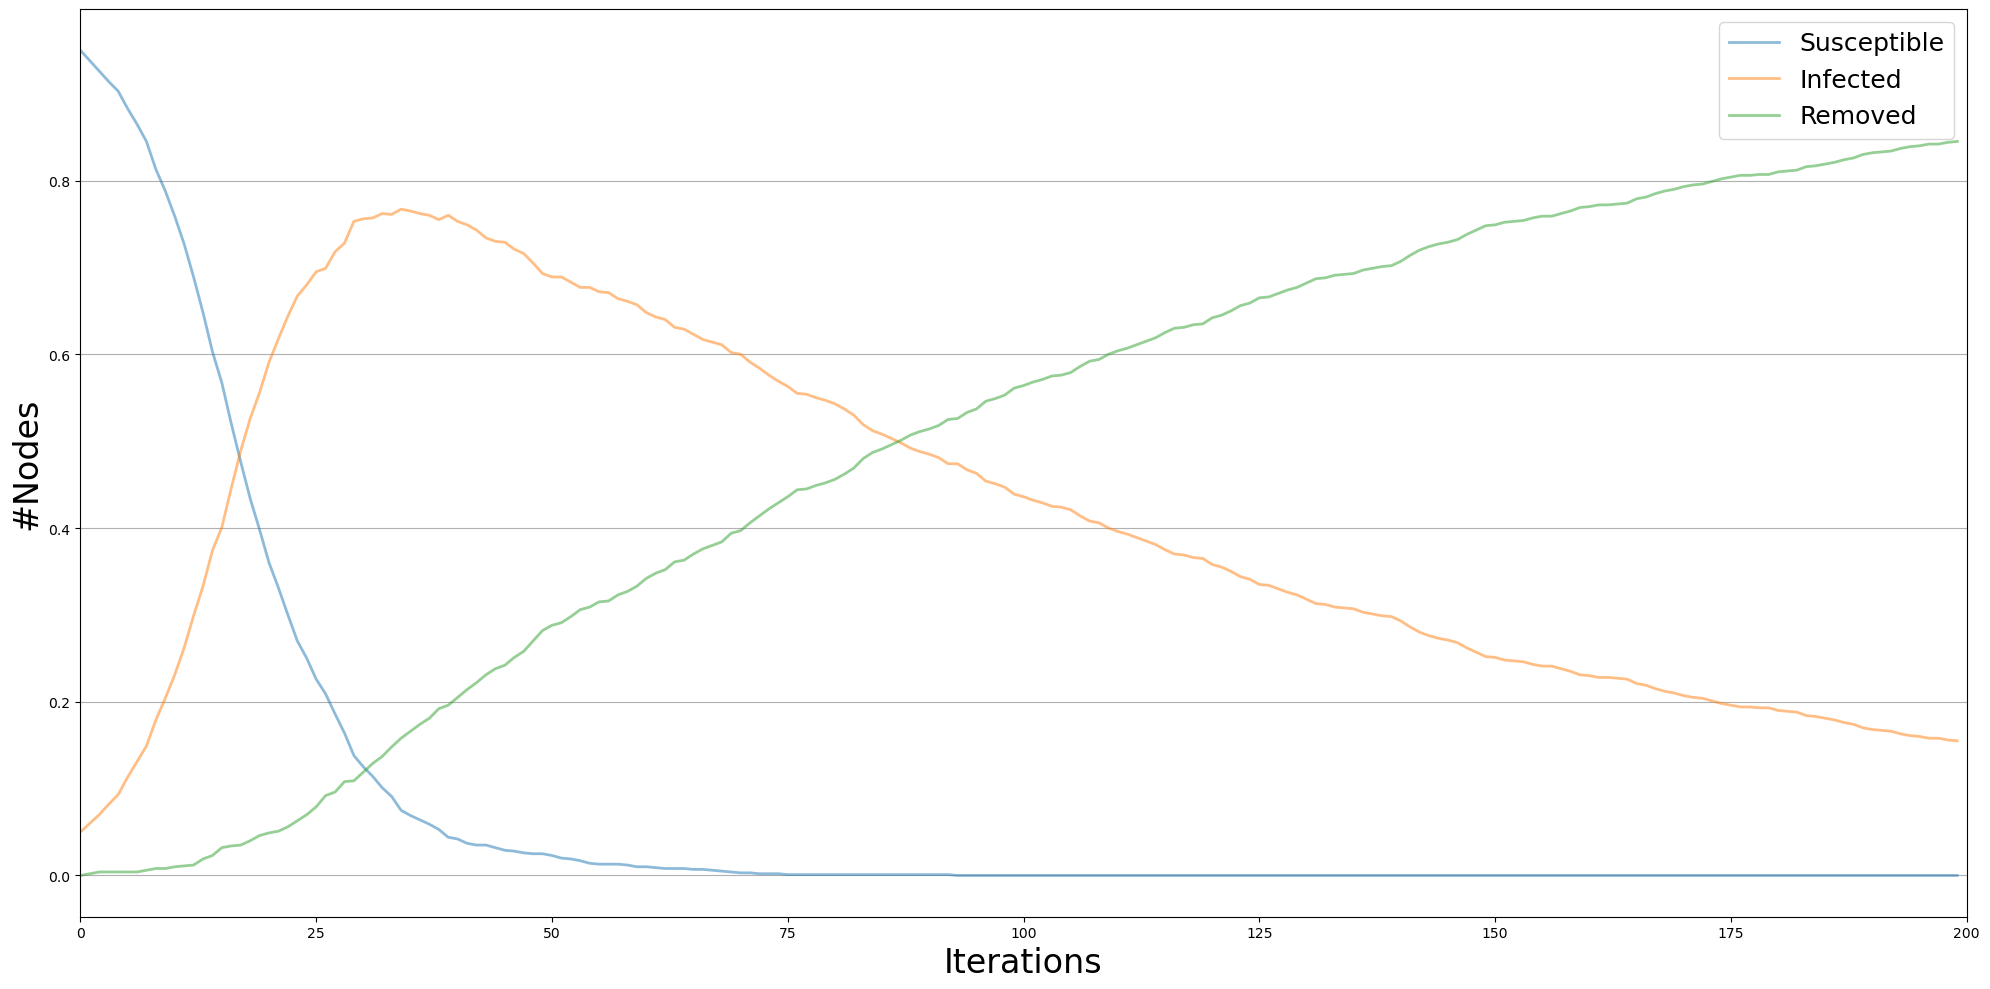

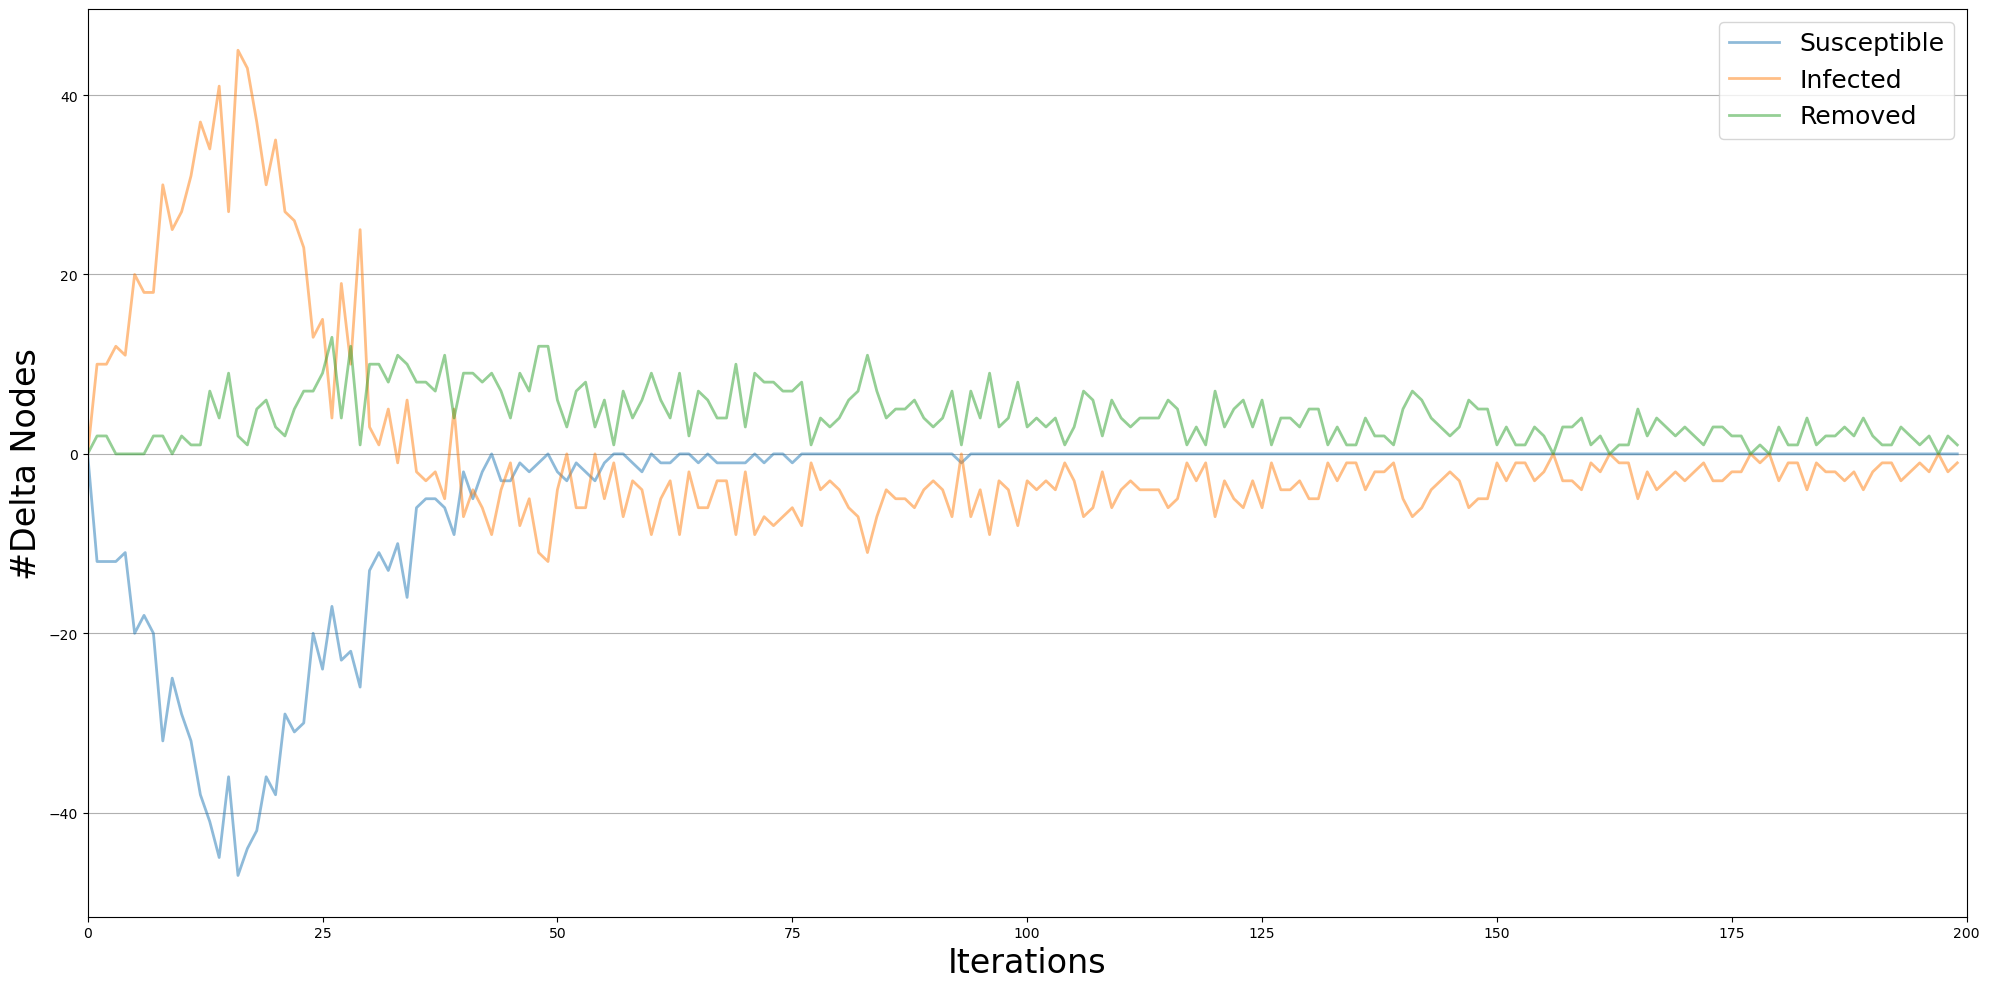

In [182]:
#Parameters
seed = 42

#Network parameters
n = 1000 # for all model types, (int) The number of nodes.
p = 0.1 # for Erdos-Reyni & Watts_strogatz, (float) Probability for edge creation & The probability of rewiring each edge, respectively.
k = 100 # for Watts_strogatz, (int) Each node is joined with its `k` nearest neighbors in a ring topology.
m = 100 # for Barabasi Albert, (int) Number of edges to attach from a new node to existing nodes.

#SIR parameters
sirBeta = 0.001
sirGamma = 0.01
fracI = 0.05
#Simulation parameters
numIterations = 200

# Network Definition
g0 = nx.erdos_renyi_graph(n, p, seed)
g1 = nx.watts_strogatz_graph(n, k, p, seed)
g2 = nx.barabasi_albert_graph(n, m, seed)
model_network_names = {g0 : 'Erdos-Reyni', g1 : 'Watts-Strogatz', g2 : 'Barabasi Albert'}

degree_sequence = np.zeros([3,n])
for g in [g0,g1,g2]:
    #average fraction that all nodes are connected to
    #high degree, betweenness and closeness, are probably most interesting measures for "interception" opportunities when vaccinating 
    
    # Model Definition
    model = ep.SIRModel(g,seed)
    # Model Configuration
    config = mc.Configuration()
    config.add_model_parameter('beta', sirBeta)
    config.add_model_parameter('gamma', sirGamma)
    config.add_model_parameter("fraction_infected", fracI)
    model.set_initial_status(config)
    
    # Simulation
    iterations = model.iteration_bunch(numIterations,progress_bar=True)
    trends = model.build_trends(iterations)
    
    #Plotting
    print(f'Network model:  {model_network_names[g]}')
    print('---Centrality measures---')
    print('Degree:')
    print(f'max     {np.max(a=list(nx.degree_centrality(g).values()))}')
    print(f'mean    {np.mean(a=list(nx.degree_centrality(g).values()))}')
    print(f'min     {np.min(a=list(nx.degree_centrality(g).values()))}')
    print()
    #Takes far too long to run and is not that useful of a measure
    #print('Betweenness:')
    #print(f'max     {np.max(a=list(nx.betweenness_centrality(g).values()))}')
    #print(f'mean    {np.mean(a=list(nx.betweenness_centrality(g).values()))}')
    #print(f'min     {np.min(a=list(nx.betweenness_centrality(g).values()))}')
    #print()
    print('Closeness:')
    print(f'max     {np.max(a=list(nx.closeness_centrality(g).values()))}')
    print(f'mean    {np.mean(a=list(nx.closeness_centrality(g).values()))}')
    print(f'min     {np.min(a=list(nx.closeness_centrality(g).values()))}')
    
    #Setting up normalized degree counts
    degree_sequence = sorted(d for n, d in g.degree())
    degs, deg_counts = np.unique(degree_sequence, return_counts=True)
    deg_counts = deg_counts/n
    #Log binning the degree counts
    x, y = logBin(degs, deg_counts, 15)
    
    #Plotting both binned and unbinned
    fig, ax = plt.subplots(2,1, figsize=[8,8])
    ax[0].plot(degs, deg_counts, 'x',color='grey',label='unbinned counts')
    ax[0].plot(x, y, 'rs', label='log-binned')
    ax[1].loglog(degs, deg_counts, 'x',color='grey',label='unbinned counts')
    ax[1].loglog(x, y, 'rs', label='log-binned')
    
    #Power law-ing the barabasi albert graph to see if it's scale-free
    if g == g2:
        m, b = np.polyfit(np.log(x[y>=0.001]), np.log(y[y>=0.001]), 1)
        ax[1].loglog(x,np.exp(m*np.log(x)+b), '--k',label=rf'$\gamma = {round(abs(m),3)}$')
    
    #More plotting
    fig.suptitle(f"Degree centrality distribution for {model_network_names[g]} network")
    ax[0].set_xlabel('Degree (Linear)')
    ax[1].set_xlabel('Degree (Log)')
    ax[0].set_ylabel('Probability (Linear)')
    ax[1].set_ylabel('Probability (Log)')
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    
    #Running the SIR model and plotting results
    viz = DiffusionTrend(model, trends)
    viz.plot()
    
    viz2 = DiffusionPrevalence(model, trends)
    viz2.plot()


#Resetting the model for next run
model.reset()